In [1]:
import os
import sys
import math
import gc

from copy import deepcopy

import numpy as np
import pandas as pd

import seaborn as sns

from scipy.spatial.distance import pdist, squareform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
device = None
os.environ["CUDA_VISIBLE_DEVICES"]="5"
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    use_cuda = True

# Ignore cuda
use_cuda = False
device = None

# Set DoubleTensor as a base type for computations
t_type = torch.float64

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext line_profiler

In [3]:
def pairwise_diffs(x, y):    
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: diffs is a NxM matrix where diffs[i,j] is the subtraaction between x[i,:] and y[j,:]
    i.e. diffs[i,j] = x[i,:]-y[j,:]
    '''
    return x[:,np.newaxis,:] - y[np.newaxis,:,:]

In [4]:
def pairwise_dists(x=None, y=None, diffs=None):
    '''
    Input: pairwise diffs is a MxN matrix where diffs[i,j] = x[i,:] - y[j, :]
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    return torch.norm(diffs, dim=2)

In [5]:
class normal_density():
    def __init__(self, n=None, mu=None, std=None):
        self.n = torch.tensor(n, dtype=t_type, device=device)
        self.mu = torch.tensor(mu, dtype=t_type, device=device)
        self.std = torch.tensor(std, dtype=t_type, device=device)
        
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        self.pi = torch.tensor(math.pi, dtype=t_type, device=device)
        
        if not n:
            self.n = torch.tensor(1., dtype=t_type, device=device)
        if not mu:
            self.mu = torch.tensor(0., dtype=t_type, device=device)
        if not std:
            self.std = torch.tensor(1., dtype=t_type, device=device)

    def __call__(self, x):
        return (torch.pow(self.two * self.pi, -self.n / self.two) * 
                torch.pow(self.std, -self.n) * 
                torch.exp(-self.one / (self.two * self.std * self.std) * torch.sum(torch.pow(x - self.mu, self.two))))
    
    def unnormed_density(self, x):
        return torch.exp(-self.one / (self.two * self.std * self.std) * torch.sum(torch.pow(x - self.mu, self.two)))

In [6]:
class SteinLinear(nn.Module):
    def __init__(self, in_features, out_features, n_particles=1, bias=True):
        super(SteinLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.n_particles = n_particles
        
        self.weight = torch.nn.Parameter(torch.zeros([n_particles, in_features, out_features], dtype=t_type))
        
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros([n_particles, 1, out_features], dtype=t_type))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(2))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            
    def forward(self, X):
        return torch.matmul(X, self.weight) + self.bias

In [7]:
arc = nn.Sequential(
    SteinLinear(10, 5, 10),
    nn.LeakyReLU(),
    SteinLinear(5, 4, 10),
    nn.LeakyReLU(),
    SteinLinear(4, 1, 10)
)

In [8]:
class SteinNet():
    def __init__(self, arc, train_size):
        '''
        p(y|x,w) = N(y|f(x,w), alpha^-1)
        p0(w) = N(w|0, betta^-1)
        
        k(w, w`) = exp^(-1/h * ||w - w`||^2)
        '''
        
        ### f(x, w)
        self.arc = arc
        if use_cuda:
            self.arc = self.arc.cuda()
            
        ### n_particles
        self.n_particles = arc[0].n_particles
        
        self.train_size = train_size
        
        ### variances from probabilistic model
        self.alpha = torch.tensor(1., dtype=t_type)
        self.betta = torch.tensor(1., dtype=t_type)
        if use_cuda:
            self.alpha = self.alpha.cuda()
            self.betta = self.betta.cuda()
            
        ### factor from kernel
        self.h = torch.tensor(1., dtype=t_type)
        if use_cuda:
            self.h = self.h.cuda()
    
    ### SUM for all j {log p(Dj|w)}
    ### return tensor [n_particles]
    def calc_data_term(self, X, y):
        two = torch.tensor(2., dtype=t_type)
        if use_cuda:
            two = two.cuda()
        
        X = X.view(1, *X.shape).expand(self.n_particles, *X.shape)
        y_p = self.arc(X).view(self.n_particles, X.shape[1])
        
        return -(torch.pow(self.alpha, two) / two) * torch.mean(torch.pow(y - y_p, two), dim=1) * self.train_size
    
    ### log p0(w)
    ### return tensor [n_particles] 
    def calc_prior_term(self):
        result = torch.zeros([self.n_particles])
        two = torch.tensor(2., dtype=t_type)
        if use_cuda:
            result = result.cuda()
            two = two.cuda()
            
        for name, param in self.arc.named_parameters():
            log_p0 = -(torch.pow(self.betta, two) / two) * torch.pow(param, two)
            result += torch.sum(log_p0.view(param.shape[0], -1), dim=1)
        return result
    
    ### k(w, w)
    ### return tensor [n_particles, n_particles]
    def calc_kernel_term(self):
        one = torch.tensor(1., dtype=t_type)
        distances = torch.zeros([self.n_particles, self.n_particles])
        if use_cuda:
            one = one.cuda()
            distances = distances.cuda()
        
        for name, param in self.arc.named_parameters():
            distances += pairwise_distances(param.view(self.n_particles, -1), param.view(self.n_particles, -1))
            
        return torch.exp(-one / self.h * distances)
    
    def update(self, X, y):
        two = torch.tensor(2., dtype=t_type)
        if use_cuda:
            two = two.cuda()
            
        prior = self.calc_prior_term
        data = self.calc_data_term
        kernel = self.calc_kernel_term
        
        log_term = prior + data
        log_term.backward()
        
        for name, param in self.arc.named_parameters():
            update_term = torch.zeros_like(param)
            
            #update_term += - two / self.h * kernel[]

In [9]:
# #X = torch.Tensor([[1, 2, 3], [2, 2, 2], [4, 3, 2]]).cuda()
# X = torch.rand([20, 10]).cuda()
# # y = torch.Tensor([1, 1, 1]).cuda()
# y = torch.rand([20]).cuda()

In [10]:
# s = SteinNet(arc, 1000)

In [11]:
# s.calc_prior_term()

In [12]:
# s.calc_data_term(X, y)

In [13]:
# s.calc_kernel_term()

In [14]:
class LinearTransform():
    def __init__(self, n_dims, n_hidden_dims, use_identity=False):
        self.n_dims = n_dims
        self.n_hidden_dims = n_hidden_dims
        self.use_identity = use_identity
        
        self.A = torch.zeros([self.n_dims, self.n_hidden_dims], dtype=t_type, device=device)
        self.tetta_0 = torch.zeros([self.n_dims, 1], dtype=t_type, device=device)
        if not self.use_identity: 
            self.A.uniform_(-1., 1.)
            self.tetta_0.uniform_(-1.,1.)
#             self.A.bernoulli_(0.1)
#             self.tetta_0.bernoulli_(0.1)
        else:
            if self.n_dims != self.n_hidden_dims:
                raise RuntimeError("Cannot use identity transformation in spaces with differrent dimensions")
            self.A = torch.eye(self.n_dims)
        ### normalize columns of matrix A
        self.A /= self.A.norm(dim=0)
        
        ### A^(t)A
        self.AtA = torch.matmul(self.A.t(), self.A)
        ### (A^(t)A)^(-1)
        self.AtA_1 = torch.inverse(self.AtA)
        ### (A^(t)A)^(-1)A^(t)
        self.inverse_base = torch.matmul(self.AtA_1, self.A.t())
        ### A(A^(t)A)^(-1)A^(t)
        self.projector_base = torch.matmul(self.A, self.inverse_base)
        
        ### factor 
    '''
        tetta - Tensor
        is t is True tetta will be transposed 
    '''
        
    ### transform tettas as follows: tetta = Atetta` + tetta_0
    def transform(self, tetta, t=False):
        if self.use_identity:
            return tetta
        if t:
            return (torch.matmul(self.A, tetta.t()) + self.tetta_0).t()
        return torch.matmul(self.A, tetta) + self.tetta_0
    
    ### apply inverse transformation
    def inverse_transform(self, tetta, t=False):
        ### tetta` = (A^(t)A)^(-1)A^(t)(tetta - tetta_0)
        if self.use_identity:
            return tetta
        if t:
            return torch.matmul(self.inverse_base, tetta.t() - self.tetta_0).t()
        return torch.matmul(self.inverse_base, tetta - self.tetta_0)
        
    ### project tettas onto Linear Space X = {Atetta` + tetta_0 for all tetta` in R^d} 
    def project(self, tetta, t=False):
        if self.use_identity:
            return tetta
        ### tetta_projected = A(A^(t)A)^(-1)A^(t)(tetta - tetta_0) + tetta_0
        if t:
            return (torch.matmul(self.projector_base, tetta.t() - self.tetta_0) + self.tetta_0).t()
        return torch.matmul(self.projector_base, tetta - self.tetta_0) + self.tetta_0
    
    ### project and then apply inverse transform to tetta - tetta_0
    def project_inverse(self, tetta, t=False):
        if self.use_identity:
            return tetta
        ### tetta_s_p_i = T^(-1)P(tetta - tetta_0)= (A^(t)A)^(-1)A^(t)tetta
        ### use solver trick: tetta_s_p_i : A^(t)Atetta_s_p_i = A^(t)tetta
        if t:
            return torch.gesv(torch.matmul(self.A.t(), tetta.t()), self.AtA)[0].t()
        return torch.gesv(torch.matmul(self.A.t(), tetta), self.AtA)[0]

In [15]:
class DistributionMover():
    def __init__(self, particles=None, n_particles=None, n_dims=None, n_hidden_dims=None, use_latent=False, target_density=None):
        if not particles and not n_particles:
            raise RuntimeError
        
        self.particles = particles
        self.n_particles = n_particles
        
        self.N = None
        
        self.n_dims = n_dims
        self.n_hidden_dims = n_hidden_dims

        self.use_latent = use_latent
        
        self.target_density=target_density
        self.real_target_density=None
        
        if not self.use_latent:
            self.n_hidden_dims = self.n_dims
        
        ### Learnable samples from the target distribution 
        if particles:
            self.n_particles = particles.shape[0]
        else:
            self.particles = torch.zeros([n_particles, self.n_hidden_dims], dtype=t_type,
                                         requires_grad=False, device=device).uniform_(-20, -10)
        self.N = torch.tensor(self.n_particles, dtype=t_type, device=device)
        
        ### Class for performing linear transformations
        self.lt = None
        if self.use_latent:
            self.lt = LinearTransform(n_dims=self.n_dims, n_hidden_dims=self.n_hidden_dims, use_identity=False)
        else:
            self.lt = LinearTransform(n_dims=self.n_dims, n_hidden_dims=self.n_hidden_dims, use_identity=True)

        ### Function of probability density of target distribution
        if target_density:
            self.target_density = target_density
        else:    
            # use unnormed probability density to speedup computations
#             self.target_density = lambda x : (0.3 * normal_density(self.n_dims, -2., 2.).unnormed_density(x) + 
#                                               0.7 * normal_density(self.n_dims, 2., 2.).unnormed_density(x))
            
#             self.real_target_density = lambda x : (0.3 * normal_density(self.n_dims, -2., 1.)(x) + 
#                                                    0.7 * normal_density(self.n_dims, 2., 1.)(x))

            self.target_density = lambda x : (normal_density(self.n_dims, 0., 2.).unnormed_density(x))
            
            self.real_target_density = lambda x : (normal_density(self.n_dims, 0., 2.)(x))
        
        ### Number of iterations since begining
        self.iter = 0
        
        ### Adagrad parameters
        self.fudge_factor = torch.tensor(1e-6, dtype=t_type, device=device)
        self.step_size = torch.tensor(1e-2, dtype=t_type, device=device)
        self.auto_corr = torch.tensor(0.9, dtype=t_type, device=device)
        
        ### Gradient history term for adagrad optimization 
        self.historical_grad = None
        if self.use_latent:
            self.historical_grad = torch.zeros([n_particles, self.n_hidden_dims], dtype=t_type, device=device)
        else:
            self.historical_grad = torch.zeros([n_particles, self.n_dims], dtype=t_type, device=device)
        
        ### Factor from kernel
        self.med = torch.tensor(0., dtype=t_type, device=device)
        self.h = torch.tensor(0., dtype=t_type, device=device)
          
        ### Support tensors for computations 
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
    
    ### k(w, w)
    ### return tuple of tensors ([n_particles, n_particles], [n_particles, n_dims])
    def calc_kernel_term(self, h_type):
        ### diffs[i, j] = tetta_i - tetta_j
        diffs = pairwise_diffs(self.particles, self.particles)
        ### dists[i, j] = ||tetta_i - tetta_j||
        dists = pairwise_dists(diffs=diffs)
        ### sq_dists[i, j] = ||tetta_i - tetta_j||^2
        sq_dists = torch.pow(dists, self.two)
    
        ### RBF Kernel
        if h_type == 0:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1)  
        elif h_type == 1:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (self.n_dims) 
        elif h_type == 2:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (2. * self.n_dims)
        elif h_type == 3:
            self.var  = torch.var(self.particles) + self.fudge_factor
            self.h =  self.var / torch.log(self.N + 1.) * (2. * self.n_dims)
        elif h_type == 4:
            self.var = torch.var(diffs) + self.fudge_factor
            self.h = self.var / torch.log(self.N + 1) * (self.n_dims)
        elif type(h_type) == float:
            self.h = h_type
        
        kernel = torch.exp(-self.one / self.h * sq_dists)
        
        grad_kernel = -self.two / self.h * kernel.unsqueeze(dim=2) * diffs

        return kernel, grad_kernel
    
    # k`(w`, w`)
    ### return tuple of tensors ([n_particles, n_particles], [n_particles, n_dims])
    def calc_kernel_term_latent(self, h_type):
        ### tetta = A tetta` + tetta_0
        real_particles = self.lt.transform(self.particles, t=True)
        ### diffs[i, j] = A(tetta`_i - tetta`_j)
        diffs = pairwise_diffs(real_particles, real_particles)
        ### dists[i, j] = ||A(tetta`_i - tetta`_j)||
        dists = pairwise_dists(diffs=diffs)
        ### sq_dists[i, j] = ||A(tetta`_i - tetta`_j)||^2
        sq_dists = torch.pow(dists, self.two)
    
        ### RBF Kernel
        if h_type == 0:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1)  
        elif h_type == 1:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (self.n_dims) 
        elif h_type == 2:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (2. * self.n_dims)
        elif h_type == 3:
            self.var  = torch.var(self.particles) + self.fudge_factor
            self.h =  self.var / torch.log(self.N + 1.) * (2. * self.n_dims)
        elif h_type == 4:
            self.var = torch.var(diffs) + self.fudge_factor
            self.h = self.var / torch.log(self.N + 1) * (self.n_dims)
        elif type(h_type) == float:
            self.h = h_type
        
        ### kernel[i, j] = exp(-1/h * ||A(tetta`_i - tetta`_j)||^2)
        kernel = torch.exp(-self.one / self.h * sq_dists)
        ### grad_kernel[i, j] = -2/h * A(tetta`_i - tetta`_j) * kernel[i, j]
        grad_kernel = -self.two / self.h * diffs * kernel.unsqueeze(2)

        return kernel, grad_kernel
    
    def calc_log_term(self):
        grad_log_term = torch.zeros([self.n_particles, self.n_dims], dtype=t_type, device=device)
    
        for idx in range(self.n_particles):
            ### tetta_i
            particle = torch.tensor(self.particles[idx], dtype=t_type, requires_grad=True, device=device)
            ### log_term_i = log p(tetta_i)
            log_term = torch.log(self.target_density(particle))
            ### grad_log_term_i = dlog_term_i / dtetta_i
            grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                         only_inputs=True, retain_graph=False, 
                                                         create_graph=False, allow_unused=False)[0]
                
        return grad_log_term
    
    def calc_log_term_latent(self):
        grad_log_term = torch.zeros([self.n_particles, self.n_dims], dtype=t_type, device=device)
    
        for idx in range(self.n_particles):
            ### tetta`_i
            particle = torch.tensor(self.particles[idx:idx+1], dtype=t_type, requires_grad=True, device=device)
            ### tetta_i = A tetta`_i + tetta_0
            real_particle = self.lt.transform(particle, t=True)
            ### log_term_i = log p(tetta_i)
            log_term = torch.log(self.target_density(real_particle))
            ### grad_log_term_i = dlog_term_i / dtetta_i
            grad_log_term[idx] = torch.autograd.grad(log_term, real_particle,
                                                         only_inputs=True, retain_graph=False, 
                                                         create_graph=False, allow_unused=False)[0]
                
        return grad_log_term
        
    def update(self, h_type):
        self.iter += 1
        
        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term(h_type)
        grad_log_term = self.calc_log_term()
        
        ### Compute value of step in functiuonal space
        phi = (torch.matmul(kernel.t(), grad_log_term) + torch.sum(grad_kernel, dim=0)) / self.N
                            
        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi
            
        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi
    
    def update_latent(self, h_type):
        self.iter += 1
        
        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term_latent(h_type)
        grad_log_term = self.calc_log_term_latent()
        
        ### Compute value of step in functiuonal space
        phi = (torch.matmul(kernel.t(), grad_log_term) + torch.sum(grad_kernel, dim=0)) / self.N
        
        ### Transform phi from R^D space to R^d space: phi` = (A^(t)A)^(-1)A^(t)phi
        phi = self.lt.project_inverse(phi, t=True)
        
        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi
            
        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi
        

In [16]:
dm = DistributionMover(n_particles=100, n_dims=2, n_hidden_dims=2, use_latent=False)

marginal_density = lambda x : (normal_density(mu=0, std=2, n=1)(x))
#marginal_density = lambda x : (0.3 * normal_density(mu=-2, std=1, n=1)(x) + 0.7 * normal_density(mu=2, std=1, n=1)(x))

pdf = []
for _ in np.linspace(-10, 10, 1000): 
    _ = torch.tensor(_, dtype=t_type, device=device)
    pdf.append(marginal_density(_))
    
from pynverse import inversefunc
from scipy.interpolate import interp1d
from scipy.integrate import quad
cum_density = interp1d(np.linspace(-20, 20, 5000), [quad(marginal_density, -20, x)[0] for x in np.linspace(-20, 20, 5000)])
inv_cum_density = inversefunc(cum_density)
real_samples = [inv_cum_density(np.random.random()) for x in range(1000)]

In [17]:
mean = quad(lambda x : marginal_density(x) * x, -20, 20)[0]
var = quad(lambda x : marginal_density(x) * (x - mean) ** 2, -20, 20)[0]

In [18]:
mean, var

(0.0, 4.0)

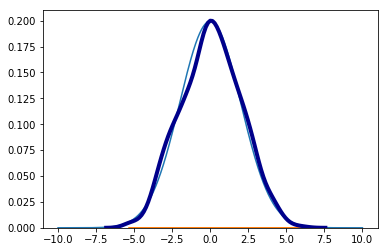

In [19]:
plt.plot(np.linspace(-10, 10, 1000), pdf)
plt.plot(real_samples, np.zeros_like(real_samples))
sns.kdeplot(real_samples, kernel='tri', color='darkblue', linewidth=4)

In [20]:
def plot_projections(dm=None, use_real=True, kernel='tri'):
    N_plots = None
    scale_factor = None
    
    if use_real:
        if not dm.use_latent:
            return
        N_plots = dm.lt.A.shape[0]
    else:
        N_plots = dm.particles.shape[1]
    if N_plots > 6:
        scale_factor = 15
    else:
        scale_factor = 5
        
    #N_plots = min(N_plots, 6)
        
    plt.figure(figsize=(3 * scale_factor, (N_plots // 3 + 1) * scale_factor))
    
    for idx in range(N_plots):
        slice_dim = idx
        
        plt.subplot(N_plots // 3 + 1, 3, idx + 1)
        
        particles = None
        if use_real:
            particles = dm.lt.transform(dm.particles, t=True)[:, slice_dim]
        else:
            particles = dm.particles[:, slice_dim]
        
        plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
        plt.plot(particles.data.cpu().numpy(), torch.zeros_like(particles).data.cpu().numpy(), 'ro')
        sns.kdeplot(particles.data.cpu().numpy(), 
                    kernel=kernel, color='darkblue', linewidth=4)

In [21]:
plot_projections(dm, use_real=True)

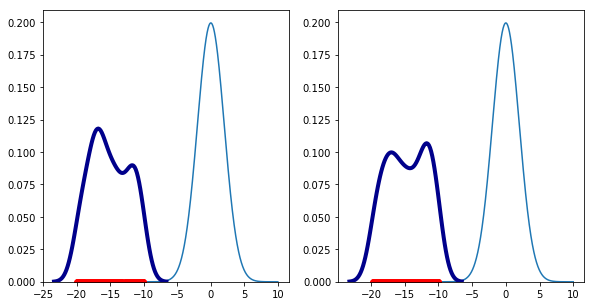

In [22]:
plot_projections(dm, use_real=False)

In [30]:
dm = DistributionMover(n_particles=100, n_dims=20, n_hidden_dims=20, use_latent=True)

In [31]:
%%time

from IPython.display import clear_output

for _ in range(3000): 
    try:
        dm.update_latent(h_type=1)
        #dm.update(h_type=0)

        if _ % 100 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))

            plot_projections(dm, use_real=True, kernel='tri')
            plot_projections(dm, use_real=False, kernel='tri')

            plt.pause(1e-300)

    except KeyboardInterrupt:
        clear_output()
        sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))

        plot_projections(dm, use_real=True, kernel='tri')
        plot_projections(dm, use_real=False, kernel='tri')

        plt.pause(1e-300)
        break

Epoch 400...
Kernel factor 1351.5043386696811CPU times: user 1min 17s, sys: 14.1 s, total: 1min 31s
Wall time: 52.8 s


In [27]:
(torch.mean(dm.lt.transform(dm.particles, t=True)),
 torch.mean(torch.std(dm.lt.transform(dm.particles, t=True), dim=0) ** 2))

(tensor(-0.0010, dtype=torch.float64), tensor(3.7448, dtype=torch.float64))

In [28]:
# #real_particles = (dm.tetta_0 + torch.matmul(dm.particles, dm.A))
# real_particles = dm.particles
# sns.kdeplot(real_particles[:,(0,1)].data.cpu().numpy(), 
#             kernel='tri', color='darkblue', linewidth=4)

In [29]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# import numpy as np


# fig = plt.figure()
# ax = fig.gca(projection='3d')

# # Make data.
# X = np.arange(-1, 3, 0.025)
# Y = np.arange(-1, 3, 0.025)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# XY = torch.stack([torch.tensor(X, dtype=t_type), torch.tensor(Y, dtype=t_type)], dim=2)
# Z = torch.zeros([XY.shape[0], XY.shape[1]])
# for idx in range(XY.shape[0]):
#     for jdx in range(XY.shape[1]):
#         Z[idx, jdx] = (0.3 * normal_density(mu=0, std=1, n=2)(XY[idx, jdx]) + 
#                        0.7 * normal_density(mu=2, std=1, n=2)(XY[idx, jdx]))
# Z = Z.cpu().data.numpy()
# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

In [30]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

class SVGD():

    def __init__(self):
        self.n_iter = 0
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = h / np.log(theta.shape[0]+1)
            
        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy * 2. / h
        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            self.n_iter += 1
            
            if debug and (iter+1) % 1000 == 0:
                print( 'iter ' + str(iter+1) )
            
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = bandwidth)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            # adagrad 
            if iter == 1:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)             
                
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
            
        return theta

In [31]:
# sys.path.insert(0, "Stein-Variational-Gradient-Descent/python/")
# from svgd import SVGD

In [32]:
dm_ex = DistributionMover(n_particles=100, n_dims=20, n_hidden_dims=2, use_latent=False)

In [33]:
dm_svgd = SVGD()

In [34]:
def lnprob(particles):
    grad_log_term = torch.zeros([particles.shape[0], particles.shape[1]], dtype=t_type, device=device)
    
    for idx in range(particles.shape[0]):
        particle = torch.tensor(particles[idx], dtype=t_type, requires_grad=True, device=device)
        log_term = torch.log(dm_ex.target_density(particle))
        grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                         only_inputs=True, retain_graph=False, 
                                                         create_graph=False, allow_unused=False)[0]
                
    return grad_log_term

In [35]:
result = dm_ex.particles.clone().detach()

In [36]:
## Compare kernel implementation

ker, grad_ker = dm_ex.calc_kernel_term(0)
print(dm_ex.h)
grad_ker_sum = torch.sum(grad_ker, dim=0)

ker_l, grad_ker_sum_l = dm_svgd.svgd_kernel(result, h=-1)

print((ker - torch.tensor(ker_l)).norm())
print((grad_ker_sum - torch.tensor(grad_ker_sum_l)).norm())

tensor(69.1647, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)


In [37]:
## Compare log_term implementation

(lnprob(result) - dm_ex.calc_log_term()).norm()

tensor(nan, dtype=torch.float64)

In [38]:
for _ in range(1):
    print(_)
    result = dm_svgd.update(result, lnprob, stepsize=1e-2, bandwidth=-1, n_iter=1000)
    result = torch.tensor(result, dtype=t_type)

0


In [39]:
for _ in range(1000):
    dm_ex.update(h_type=0)
    if _ % 15 == 0:
        print(_)

0
15
30
45
60
75
90
105
120
135
150
165
180
195
210
225
240
255
270
285
300
315
330
345
360
375
390
405
420
435
450
465
480
495
510
525
540
555
570
585
600
615
630
645
660
675
690
705
720
735
750
765
780
795
810
825
840
855
870
885
900
915
930
945
960
975
990


In [40]:
(result - dm_ex.particles).norm()

tensor(nan, dtype=torch.float64)

ValueError: array must not contain infs or NaNs

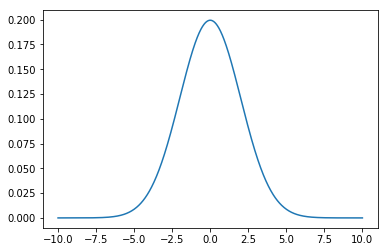

In [41]:
plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
plt.plot(result.data.cpu().numpy(), torch.zeros_like(result).data.cpu().numpy(), 'ro')
sns.kdeplot(result.data.cpu().numpy()[:,0], 
            kernel='tri', color='darkblue', linewidth=4)

In [ ]:
plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
plt.plot(dm_ex.particles.data.cpu().numpy(), torch.zeros_like(dm_ex.particles).data.cpu().numpy(), 'ro')
sns.kdeplot(dm_ex.particles.data.cpu().numpy()[:,0], 
            kernel='tri', color='darkblue', linewidth=4)